In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

variables_df = pd.read_csv('variables_df.csv',index_col=[0])

variables_dict = variables_df.to_dict()['0']
batch_size = int(variables_dict['batch_size_valid'])
window_size = int(variables_dict['window_size'])
sentiment = bool(variables_dict['sentiment'])
sentiment_type = variables_dict['sentiment_type']
ticker = variables_dict['ticker']
excel_reports = variables_dict['excel_reports']
entry_candle = variables_dict['entry_candle']
model_name = variables_dict['model_name']
indicator1 = int(variables_dict['indicator1'])
indicator2 = int(variables_dict['indicator2'])
indicator3 = int(variables_dict['indicator3'])
aggr_function = variables_dict['aggr_function']
condition = bool(variables_dict['condition'])
period = variables_dict['period']
formation_window = int(variables_dict['formation_window'])


In [2]:
x_test = pd.read_csv(f'{ticker}_test_data.csv',index_col=[0])
x_test_x = pd.read_csv(f'{ticker}_x_test_x.csv',index_col=[0])
news_df = pd.read_excel(f'{ticker}_sentiment_analysis_final.xlsx',index_col=[0])
Dates = pd.read_csv(f'{ticker}_Dates.csv',index_col=[0])
Dates = Dates.iloc[:,0] 

In [3]:
#Load model
model_name = variables_dict['model_name']

def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                        penalty * tf.square(y_true-y_pred),
                        tf.square(y_true - y_pred)
                        )

    return(tf.reduce_mean(loss, axis=-1))

tf.keras.losses.sign_penalty = sign_penalty
model = tf.keras.models.load_model(model_name, custom_objects={
                                           'sign_penalty': sign_penalty})
from functions import model_forecast

forecast = model_forecast(model, x_test, window_size=window_size, debug=False)
forecast


31/31 [==============================] - 3s 39ms/step


array([0.6061249 , 0.5686266 , 0.55819464, 0.53401965, 0.48594537,
       0.5113487 , 0.51379824, 0.52254266, 0.54147905, 0.5283686 ,
       0.44721305, 0.41574362, 0.49567997, 0.52149445, 0.5764752 ,
       0.59513825, 0.51007503, 0.47818178, 0.49892345, 0.6323539 ,
       0.64881015, 0.63620704, 0.65049887, 0.6709478 , 0.676971  ,
       0.64396626, 0.6228109 , 0.6133658 , 0.58728635, 0.6153913 ,
       0.64233917], dtype=float32)

In [4]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(window_size=window_size, batch_size=batch_size, train=False, debug=False)

x_test_tensors, labels = GetTensoredValidDataset.transform(x_test)

from transformers_preprocess import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_test=x_test, x_test_x=x_test_x, window_size=window_size, debug=False,
                         sentiment=sentiment,sentiment_type=sentiment_type)

df = ReverseNormalization.transform()

from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_test=x_test,
                      sentiment=sentiment,
                      sentiment_type=sentiment_type)

reversed_df = GetFinalDataframe.transform(df)

from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',#Current Open
                        budget=10000,
                        window_size=window_size,
                        export_excel=False,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)

from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle=entry_candle,
                        budget=10000,
                        window_size=window_size,
                        export_excel=False,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
#trades_df_final

--------> GetTensoredDataset completed

--------> ReverseNormalization completed

--------> GetFinalDataframe

ticker: CLB

Formations:  31
period: 2022-05-09 - 2023-01-02
Entry Candle:  Current Open

Total Trades:  25
Profit Trades:  16
Loss Trades:  9

Win Ratio: 64.0 %
Loss Ratio: 36 %

Trade nr with exact TP:  4
Ratio of exact TP: 16.0 %

Average profit per trade:  306

Gross profit:  7659
Gross loss:  -7778

Net profit:  -119
--------> GetPerformanceReport completed



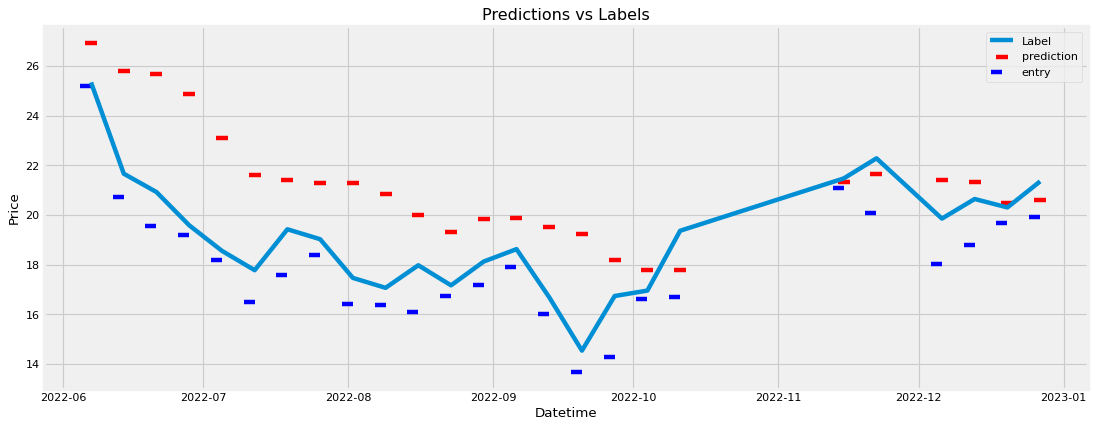

In [5]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
figure(figsize=(15, 6), dpi=80)

df_plot = trades_df_final[['Datetime','labels','prediction','Entry']]
df_plot = df_plot[df_plot.labels != 'nn']

x1 = df_plot['labels']
x2 = df_plot['prediction']
entry = df_plot['Entry']
y = df_plot['Datetime']

# plot lines
plt.plot(y, x1, label = "Label")
plt.scatter(y, x2, label = "prediction",color='red', s=100,marker='_')
plt.scatter(y, entry, label = "entry",color='blue', s=100,marker=0)
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Predictions vs Labels')
plt.legend()
plt.show()

In [ ]:
from final_evaluation import MakeSinglePrediction

#model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{sentiment}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date="2019-03-18",
                        end_date="2022-11-27",
                        interval=period, #1wk
                        progress=False,
                        condition=condition,
                        timeperiod1=indicator1,
                        timeperiod2=indicator2,
                        timeperiod3=indicator3,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Close',
                        news_df=news_df,
                        sentiment=sentiment,
                        sentiment_type = sentiment_type,
                        sentiment_aggr = aggr_function)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.head(formation_window)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method
final_trade_formation


In [ ]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart and sentiment
from plotting import PlotCurrentFormation

PlotCurrentFormation(final_trade_formation,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
